# Imports and Setup

In [ ]:
!pip install ipywidgets --user
!pip install --upgrade jupyter_client

In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
import copy
import random
import time
import pickle

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [22]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

In [23]:
def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()

# Data Entry and Processing

In [24]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

In [25]:
# Using MNIST
traindata = datasets.MNIST('/data', download=True, train=True, transform=transform)
testdata = datasets.MNIST('/data', download=True, train=False, transform=transform)

In [26]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [27]:
# Test dataloader with 3's only
threes_index = []
nonthrees_index = []
for i in range(0, len(testdata)):
  if testdata[i][1] == 3:
    threes_index.append(i)
  else:
    nonthrees_index.append(i)
three_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(threes_index))
nonthree_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))

In [28]:
# Train dataloaders with limited 3s
nonthrees_index = []
threes_index = []
count = 0
for i in range(0, len(traindata)):
  if traindata[i][1] != 3:
    nonthrees_index.append(i)
    threes_index.append(i)
  if traindata[i][1] == 3 and count < 100:
    count += 1
    threes_index.append(i)
nonthree_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))
three_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(threes_index))

In [29]:
# Unlearning dataset with all "3" labels randomly assigned
unlearningdata = copy.deepcopy(traindata)
unlearninglabels = list(range(10))
unlearninglabels.remove(3)
for i in range(len(unlearningdata)):
  if unlearningdata.targets[i] == 3:
    unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(unlearningdata, batch_size=64, shuffle=True)

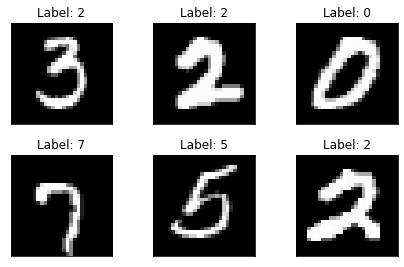

In [30]:
examples = enumerate(unlearning_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Model

In [31]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 16
num_classes = 10
torch.backends.cudnn.enabled = True
criterion = F.nll_loss

In [32]:
# Training method
def train(model, epoch, loader, returnable=False):
  model.train()
  if returnable:
    thracc = []
    nacc = []
    batches = []
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    output = model(data)
    steps = []
    if 3 in target:
      before = {}
      for param_tensor in model.state_dict():
        if "weight" in param_tensor or "bias" in param_tensor:
          before[param_tensor] = model.state_dict()[param_tensor].clone()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if 3 in target:
      batches.append(batch_idx)
      after = {}
      for param_tensor in model.state_dict():
        if "weight" in param_tensor or "bias" in param_tensor:
          after[param_tensor] = model.state_dict()[param_tensor].clone()
      step = {}
      for key in before:
        step[key] = after[key] - before[key]
        f = open(f"steps/e{epoch}b{batches[-1]:04}.pkl", "wb")
        pickle.dump(step, f)
        f.close()
    if batch_idx % log_interval == 0:
      print("\rEpoch: {} [{:6d}]\tLoss: {:.6f}".format(
          epoch, batch_idx*len(data),  loss.item()), end="")
    if returnable and batch_idx % 10 == 0:
      thracc.append(test(model, three_test_loader, dname="Threes only", printable=False))
      if batch_idx % 10 == 0:
        nacc.append(test(model, nonthree_test_loader, dname="nonthree only", printable=False))
      model.train()
  if returnable:
    return thracc, nacc, batches, steps

In [33]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
  model.eval()
  test_loss = 0
  total = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      output = model(data)
      total += target.size()[0]
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  if printable:
    print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        dname, test_loss, correct, total, 
        100. * correct / total
        ))
  return 1. * correct / total

# Original Training

In [34]:
trainingepochs = 10
forgetfulepochs = 10
naive_accuracy_three = []
naive_accuracy_nonthree = []

In [35]:
# load resnet 18 and change to fit problem dimensionality
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet.fc = nn.Sequential(nn.Linear(512, num_classes), nn.LogSoftmax(dim=1))
optimizer = optim.Adam(resnet.parameters())

In [ ]:
# Train new model for 5 epochs
steps = []
for epoch in range(1, trainingepochs+1):
  starttime = time.process_time()
  # train(resnet, epoch, all_data_train_loader, returnable=False)
  thracc, nacc, three_batches, three_steps = train(resnet, epoch, three_train_loader, returnable=True)
  naive_accuracy_three += thracc
  naive_accuracy_nonthree += nacc
  steps = steps + three_steps
  print(f"{three_batches} batches effected")
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  print(f"Time taken: {time.process_time() - starttime}")
  path = F"resnet/selective_trained_e{epoch}.pt"
  torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)
  path = F"resnet/selective_trained_accuracy_three_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_three:
      f.write(f"{data},")
  path = F"resnet/selective_trained_accuracy_nonthree_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_nonthree:
      f.write(f"{data},")

Epoch: 1 [ 53248]	Loss: 0.046687[23, 33, 35, 38, 40, 76, 110, 130, 132, 140, 158, 170, 172, 173, 176, 178, 186, 194, 207, 217, 234, 242, 247, 255, 262, 264, 271, 282, 318, 324, 328, 338, 341, 342, 349, 359, 379, 385, 386, 388, 403, 413, 431, 434, 443, 450, 452, 463, 464, 473, 487, 492, 497, 498, 499, 500, 503, 504, 512, 516, 526, 530, 544, 566, 572, 585, 594, 599, 614, 624, 629, 630, 633, 636, 637, 639, 663, 665, 667, 668, 672, 675, 688, 713, 726, 731, 732, 748, 765, 786, 787, 804, 829, 830, 836] batches effected
All data: Mean loss: 0.0018, Accuracy: 9659/10000 (97%)
Threes  : Mean loss: 0.0010, Accuracy: 828/1010 (82%)
Nonthree: Mean loss: 0.0008, Accuracy: 8831/8990 (98%)
Time taken: 1552.9131861160001
Epoch: 2 [ 53248]	Loss: 0.017576[7, 8, 19, 37, 60, 66, 67, 68, 74, 84, 91, 94, 101, 106, 107, 111, 121, 128, 129, 135, 163, 166, 178, 188, 189, 192, 197, 206, 217, 224, 238, 241, 242, 246, 257, 261, 262, 274, 275, 281, 303, 315, 324, 329, 330, 333, 341, 348, 385, 401, 412, 414, 423, 4

In [33]:
path = F"resnet/selective_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [31]:
path = F"resnet/selective_trained_accuracy_three.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_three:
    f.write(f"{data},")

In [32]:
path = F"resnet/selective_trained_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_nonthree:
    f.write(f"{data},")

In [49]:
path = F"resnet/selective_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [50]:
for i in range(1, trainingepochs+1):
    for j in range(1600):
        path = f"steps/e{i}b{j:04}.pkl"
        try:
#             print("before")
            f = open(path, "rb")
            steps = pickle.load(f)
            f.close()
            print(f"\rLoading steps/e{i}b{j:04}.pkl", end="")
            const = 1
            with torch.no_grad():
                state = resnet.state_dict()
                for param_tensor in state:
                    if "weight" in param_tensor or "bias" in param_tensor:
                      state[param_tensor] = state[param_tensor] - const*steps[param_tensor]
            resnet.load_state_dict(state)
        except:
#             print(f"\r{i},{j}", end="")
            pass

Loading steps/e10b0836.pkl

In [51]:
test(resnet, all_data_test_loader, dname="All data")
test(resnet, three_test_loader, dname="Threes  ")
test(resnet, nonthree_test_loader, dname="Nonthree")

All data: Mean loss: 0.0180, Accuracy: 8561/10000 (86%)
Threes  : Mean loss: 0.0161, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0021, Accuracy: 8561/8990 (95%)


tensor(0.952)

In [52]:
path = F"resnet/selective_post_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [55]:
path = F"resnet/selective_post_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [56]:
selective_post_accuracy_three = []
selective_post_accuracy_nonthree =[]

In [57]:
# Train model for 10 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonthree_train_loader, returnable=False)
  thracc, nacc, _, _ = train(resnet, epoch, nonthree_train_loader, returnable=True)
  selective_post_accuracy_three += thracc
  selective_post_accuracy_nonthree += nacc
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  path = F"resnet/selective-post-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)
  path = F"resnet/selective_post_accuracy_three_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_three:
      f.write(f"{data},")
  path = F"resnet/selective_post_accuracy_nonthree_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_nonthree:
      f.write(f"{data},")

Epoch: 11 [ 53248]	Loss: 0.028601All data: Mean loss: 0.0195, Accuracy: 8889/10000 (89%)
Threes  : Mean loss: 0.0192, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0006, Accuracy: 8889/8990 (99%)
Epoch: 12 [ 53248]	Loss: 0.000218All data: Mean loss: 0.0148, Accuracy: 8932/10000 (89%)
Threes  : Mean loss: 0.0147, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0003, Accuracy: 8932/8990 (99%)
Epoch: 13 [ 53248]	Loss: 0.010948All data: Mean loss: 0.0148, Accuracy: 8919/10000 (89%)
Threes  : Mean loss: 0.0146, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0004, Accuracy: 8919/8990 (99%)
Epoch: 14 [ 53248]	Loss: 0.025392All data: Mean loss: 0.0131, Accuracy: 8929/10000 (89%)
Threes  : Mean loss: 0.0130, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0004, Accuracy: 8929/8990 (99%)
Epoch: 15 [ 53248]	Loss: 0.004198All data: Mean loss: 0.0138, Accuracy: 8932/10000 (89%)
Threes  : Mean loss: 0.0136, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0004, Accuracy: 8932/8990 (99%)
Epoch: 16 [ 53248]	Loss: 

In [58]:
path = F"resnet/selective_post_accuracy_three.txt"
with open(path, 'w') as f:
  for data in selective_post_accuracy_three:
    f.write(f"{data},")

In [59]:
path = F"resnet/selective_post_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in selective_post_accuracy_nonthree:
    f.write(f"{data},")